In [78]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from scipy.stats import ks_2samp
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


Os dados começaram a obter um índice adequado de preenchimento a partir de 2020. Portanto, vamos desconsiderar os anos anteriores para este projeto.

In [79]:
# Caminho para o diretório onde estão os datasets
diretorio = 'data/raw/'

# Lista para armazenar cada DataFrame
dataframes = []

# Loop através dos anos dos datasets
for ano in range(2020, 2024):
    arquivo = os.path.join(diretorio, f'acidentes_{ano}.csv')
    if os.path.exists(arquivo):
        df = pd.read_csv(arquivo, delimiter = ';')
        print(len(df))
        dataframes.append(df)
    else:
        print(f"Não foi possível encontrar o arquivo de nome: {arquivo}")

# Concatenar todos os DataFrames em um só
df_acidentes = pd.concat(dataframes, ignore_index=True)


4092
2380
2669
31567


Obs importante: o dataset possui uma quantidade muito maior de  dados em 2023

In [80]:
df_acidentes.head(2)

,data,hora,natureza_acidente,situacao,bairro,endereco,numero,detalhe_endereco_acidente,complemento,bairro_cruzamento,num_semaforo,sentido_via,tipo,descricao,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas,vitimasfatais,acidente_verificado,tempo_clima,situacao_semaforo,sinalizacao,condicao_via,conservacao_via,ponto_controle,situacao_placa,velocidade_max_via,mao_direcao,divisao_via1,divisao_via2,divisao_via3,Protocolo,natureza
0,2020-01-01,00:39:00,SEM VÍTIMA,CANCELADA,ÁGUA FRIA,RUA SAO SEBASTIAO,1687,NaN,EM FRENTE A IGREJA UNIVERSAL,ÁGUA FRIA,NaN,NaN,COLISÃO,COLISÃO ENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,01:04:00,SEM VÍTIMA,FINALIZADA,CORDEIRO,AV CAXANGA,1444,AV GENERAL SAN MARTIN,NaN,CORDEIRO,80.0,SUBURBIO,ABALROAMENTO LONGITUDINAL,COLISÃO ENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Cruzamento,Bom,Sem defeito,Perfeito estado,Seca,Perfeito estado,Faixa de pedestre,NaN,60 km/h,Dupla,Canteiro central,NaN,NaN,NaN,NaN


# Tipagem de dados

In [81]:
df_acidentes.dtypes

data                         object
hora                         object
natureza_acidente            object
situacao                     object
bairro                       object
endereco                     object
numero                       object
detalhe_endereco_acidente    object
complemento                  object
bairro_cruzamento            object
num_semaforo                 object
sentido_via                  object
tipo                         object
descricao                    object
auto                         object
moto                         object
ciclom                       object
ciclista                     object
pedestre                     object
onibus                       object
caminhao                     object
viatura                      object
outros                       object
vitimas                      object
vitimasfatais                object
acidente_verificado          object
tempo_clima                  object
situacao_semaforo           

### O que podemos observar?

A tipagem não está bem definida, com quase todos os campos com tipo " object ". Podemos utilizar os metadados que obtivemos junto com o dataset para mapear e corrigir a tipagem das colunas mais importantes. 


In [82]:
#tratando possíveis erros na tipagem dos dados a partir dos metadados existentes.

def ajustar_tipos(df, tipos):
    for coluna, tipo in tipos.items():
        if coluna in df.columns:
            if tipo == 'datetime64':
                df[coluna] = pd.to_datetime(df[coluna], errors='coerce')  # Converte para datetime, erro se falhar
            elif tipo == 'float64' or tipo == float:
                # Antes de converter para float, remove espaços, substitui vírgulas por pontos e trata erros
                df[coluna] = df[coluna].apply(lambda x: str(x).strip().replace(',', '.')).astype(float)
            #elif coluna == 'hora' and tipo == 'hora':
                # Convertendo a string de hora para tipo de hora pandas, manipulando erros
                #df[coluna] = pd.to_datetime(df[coluna], format='%H:%M:%S', errors='coerce').dt.time
            else:
                df[coluna] = df[coluna].astype(tipo)  # Aplica outros tipos conforme especificado


tipo_de_dados = {
    'tipo': str,
    'situacao': str,
    'data': 'datetime64',
    #'hora': 'hora',
    'bairro': str,
    'endereco': str,
    'complemento': str,
    'natureza': str,
    'descricao': str,
    'auto': float,
    'moto': float,
    'ciclom': float,
    'ciclista': float,
    'pedestre': float,
    'onibus': float,
    'caminhao': float,
    'viatura': float,
    'outros': float,
    'vitimas': float,
    'vitimasfatais': float
}

# Suponha que df_acidentes seja o DataFrame que você está utilizando
ajustar_tipos(df_acidentes, tipo_de_dados)


In [83]:
df_acidentes.dtypes

data                         datetime64[ns]
hora                                 object
natureza_acidente                    object
situacao                             object
bairro                               object
endereco                             object
numero                               object
detalhe_endereco_acidente            object
complemento                          object
bairro_cruzamento                    object
num_semaforo                         object
sentido_via                          object
tipo                                 object
descricao                            object
auto                                float64
moto                                float64
ciclom                              float64
ciclista                            float64
pedestre                            float64
onibus                              float64
caminhao                            float64
viatura                             float64
outros                          

In [84]:
df_acidentes.describe()

,data,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas,vitimasfatais
count,40540,40100.000000,38308.000000,36635.000000,36768.000000,36771.000000,37107.000000,36911.000000,36688.000000,36676.000000,40694.000000,36637.000000
mean,2023-01-05 23:58:13.438579200,0.364040,0.220058,0.001720,0.016482,0.021484,0.030668,0.027986,0.014800,0.003681,0.262373,0.002921
min,2020-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-01-15 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2023-05-20 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2023-09-15 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2024-12-31 00:00:00,9.000000,8.000000,1.000000,3.000000,5.000000,3.000000,15.000000,11.000000,12.000000,21.000000,6.000000
std,NaN,0.645533,0.457814,0.041434,0.129439,0.154264,0.177350,0.191819,0.134428,0.094930,0.549330,0.064133


In [85]:
df_acidentes.head(3 )

,data,hora,natureza_acidente,situacao,bairro,endereco,numero,detalhe_endereco_acidente,complemento,bairro_cruzamento,num_semaforo,sentido_via,tipo,descricao,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas,vitimasfatais,acidente_verificado,tempo_clima,situacao_semaforo,sinalizacao,condicao_via,conservacao_via,ponto_controle,situacao_placa,velocidade_max_via,mao_direcao,divisao_via1,divisao_via2,divisao_via3,Protocolo,natureza
0,2020-01-01,00:39:00,SEM VÍTIMA,CANCELADA,ÁGUA FRIA,RUA SAO SEBASTIAO,1687,NaN,EM FRENTE A IGREJA UNIVERSAL,ÁGUA FRIA,NaN,NaN,COLISÃO,COLISÃO ENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
1,2020-01-01,01:04:00,SEM VÍTIMA,FINALIZADA,CORDEIRO,AV CAXANGA,1444,AV GENERAL SAN MARTIN,nan,CORDEIRO,80.0,SUBURBIO,ABALROAMENTO LONGITUDINAL,COLISÃO ENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Cruzamento,Bom,Sem defeito,Perfeito estado,Seca,Perfeito estado,Faixa de pedestre,NaN,60 km/h,Dupla,Canteiro central,NaN,NaN,NaN,nan
2,2020-01-01,02:16:00,SEM VÍTIMA,FINALIZADA,AREIAS,AV RECIFE,NaN,NaN,LADO OPOSTO AO RESIDENCIAL IGNEZ ANDREAZZA,AREIAS,494.0,SUBURBIO,CHOQUE VEÍCULO PARADO,COLISÃO ENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Longo da via,Bom,Sem defeito,Perfeito estado,Seca,Perfeito estado,Faixa de pedestre,Não há placas,NaN,Dupla,Canteiro central,NaN,NaN,NaN,nan


# Enriquecimento de Dados

Essa é uma etapa extra, mas acredito que seja interessante enriquecer nosso dataset ao adicionarmos informações que podem ser inferidas. O objetivo é facilitar possíveis filtros, agregações de dados e análises categóricas.

In [86]:
# Enriquecimento envolvendo características de data e hora. 

def get_season(month):
    if month in [12, 1, 2]:
        return 'Verão'
    elif month in [3, 4, 5]:
        return 'Outono'
    elif month in [6, 7, 8]:
        return 'Inverno'
    elif month in [9, 10, 11]:
        return 'Primavera'




df_acidentes['dia_da_semana'] = df_acidentes['data'].dt.day_name()
df_acidentes['mes'] = df_acidentes['data'].dt.month
df_acidentes['ano'] = df_acidentes['data'].dt.year
df_acidentes['estacao'] = df_acidentes['data'].dt.month.apply(get_season)

# Tratamento de Dados Ausentes

In [87]:
#analisando quantidades de nulos

nulos_por_coluna = df_acidentes.isnull().sum()
print(nulos_por_coluna)

data                           168
hora                          2837
natureza_acidente            34237
situacao                         0
bairro                           0
endereco                         0
numero                       24311
detalhe_endereco_acidente    30375
complemento                      0
bairro_cruzamento              148
num_semaforo                 37109
sentido_via                  33264
tipo                             0
descricao                        0
auto                           608
moto                          2400
ciclom                        4073
ciclista                      3940
pedestre                      3937
onibus                        3601
caminhao                      3797
viatura                       4020
outros                        4032
vitimas                         14
vitimasfatais                 4071
acidente_verificado          33541
tempo_clima                  33424
situacao_semaforo            33513
sinalizacao         

In [88]:
#Percentual de nulos

percentual_nulos = (df_acidentes.isnull().sum() / len(df_acidentes)) * 100
print(percentual_nulos)

data                          0.412695
hora                          6.969146
natureza_acidente            84.103862
situacao                      0.000000
bairro                        0.000000
endereco                      0.000000
numero                       59.720448
detalhe_endereco_acidente    74.616783
complemento                   0.000000
bairro_cruzamento             0.363565
num_semaforo                 91.158986
sentido_via                  81.713668
tipo                          0.000000
descricao                     0.000000
auto                          1.493564
moto                          5.895647
ciclom                       10.005404
ciclista                      9.678687
pedestre                      9.671318
onibus                        8.845927
caminhao                      9.327405
viatura                       9.875209
outros                        9.904687
vitimas                       0.034391
vitimasfatais                10.000491
acidente_verificado      

#### Remoção de colunas

É possível observar que o percentual de nulos em algumas colunas do dataframe é muito alto para realizarmos imputação. Realizaremos um recorte das colunas que possuem quantidade de nulos maior que 25% para trabalharmos com dados mais consistentes.

In [89]:
# Removendo colunas com índice de nulos maior que 25%:

df_acidentes = df_acidentes.loc[:, df_acidentes.isnull().sum() / len(df_acidentes) < 0.25]


In [90]:
percentual_nulos = (df_acidentes.isnull().sum() / len(df_acidentes)) * 100
print(percentual_nulos)

data                  0.412695
hora                  6.969146
situacao              0.000000
bairro                0.000000
endereco              0.000000
complemento           0.000000
bairro_cruzamento     0.363565
tipo                  0.000000
descricao             0.000000
auto                  1.493564
moto                  5.895647
ciclom               10.005404
ciclista              9.678687
pedestre              9.671318
onibus                8.845927
caminhao              9.327405
viatura               9.875209
outros                9.904687
vitimas               0.034391
vitimasfatais        10.000491
Protocolo            15.901051
natureza              0.000000
dia_da_semana         0.412695
mes                   0.412695
ano                   0.412695
estacao               0.412695
dtype: float64


#### Preenchimento da coluna natureza_acidente

Note que a coluna de natureza_acidente, removida na etapa anterior, possuia um índice de nulos muito alto, e foi descartada. No entanto, é possível obter essa informação a partir das colunas que representam as vítimas e as vítimas fatais. Essa coluna categória é muito importante para as análises que realizaremos posteriormente.

In [91]:
def classificar_acidente(row):
    if row['vitimasfatais'] > 0:
        return 'Fatal'
    elif row['vitimas'] > 0:
        return 'Não fatal'
    else:
        return 'Sem vítimas'

df_acidentes['natureza_acidente'] = df_acidentes.apply(classificar_acidente, axis=1)

#### Imputação de dados

Realizaremos a imputação de dados ausentes em colunas que possuem quantidade de nulos entre 5% e 15% utilizando KNN.

In [92]:
# Lista das colunas a serem imputadas
colunas_para_imputar = ['moto', 'ciclom', 'ciclista', 'pedestre', 'onibus', 'caminhao', 'viatura', 'outros']

# Inicializar o KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Aplicar o KNNImputer às colunas selecionadas
df_acidentes[colunas_para_imputar] = knn_imputer.fit_transform(df_acidentes[colunas_para_imputar])


In [93]:
#Percentual de nulos após imputação

novo_percentual_nulos = (df_acidentes.isnull().sum() / len(df_acidentes)) * 100
print(novo_percentual_nulos)

data                  0.412695
hora                  6.969146
situacao              0.000000
bairro                0.000000
endereco              0.000000
complemento           0.000000
bairro_cruzamento     0.363565
tipo                  0.000000
descricao             0.000000
auto                  1.493564
moto                  0.000000
ciclom                0.000000
ciclista              0.000000
pedestre              0.000000
onibus                0.000000
caminhao              0.000000
viatura               0.000000
outros                0.000000
vitimas               0.034391
vitimasfatais        10.000491
Protocolo            15.901051
natureza              0.000000
dia_da_semana         0.412695
mes                   0.412695
ano                   0.412695
estacao               0.412695
natureza_acidente     0.000000
dtype: float64


# Normalização e Discretização

In [94]:
# Normalização
df_acidentes_normalizado = df_acidentes.copy()

scaler = MinMaxScaler()
numeric_cols = df_acidentes_normalizado.select_dtypes(include=['int64', 'float64']).columns

df_acidentes_normalizado[numeric_cols] = scaler.fit_transform(df_acidentes_normalizado[numeric_cols])




In [95]:
df_acidentes_normalizado.head()

,data,hora,situacao,bairro,endereco,complemento,bairro_cruzamento,tipo,descricao,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas,vitimasfatais,Protocolo,natureza,dia_da_semana,mes,ano,estacao,natureza_acidente
0,2020-01-01,00:39:00,CANCELADA,ÁGUA FRIA,RUA SAO SEBASTIAO,EM FRENTE A IGREJA UNIVERSAL,ÁGUA FRIA,COLISÃO,COLISÃO ENTRE DOIS AUTOS S/V,0.222222,0.027507,0.00172,0.005494,0.004297,0.010223,0.001866,0.001345,0.000307,0.0,NaN,NaN,nan,Wednesday,0.0,0.0,Verão,Sem vítimas
1,2020-01-01,01:04:00,FINALIZADA,CORDEIRO,AV CAXANGA,nan,CORDEIRO,ABALROAMENTO LONGITUDINAL,COLISÃO ENTRE DOIS AUTOS S/V,0.222222,0.027507,0.00172,0.005494,0.004297,0.010223,0.001866,0.001345,0.000307,0.0,NaN,NaN,nan,Wednesday,0.0,0.0,Verão,Sem vítimas
2,2020-01-01,02:16:00,FINALIZADA,AREIAS,AV RECIFE,LADO OPOSTO AO RESIDENCIAL IGNEZ ANDREAZZA,AREIAS,CHOQUE VEÍCULO PARADO,COLISÃO ENTRE DOIS AUTOS S/V,0.222222,0.027507,0.00172,0.005494,0.004297,0.010223,0.001866,0.001345,0.000307,0.0,NaN,NaN,nan,Wednesday,0.0,0.0,Verão,Sem vítimas
3,2020-01-01,02:22:00,FINALIZADA,BOA VIAGEM,AV BOA VIAGEM,EM FRENTE AO 1º JARDIM B. VIAGEM,BOA VIAGEM,COLISÃO TRASEIRA,COLISÃO ENTRE DOIS AUTOS S/V,0.222222,0.027507,0.00172,0.005494,0.004297,0.010223,0.001866,0.001345,0.000307,0.0,NaN,NaN,nan,Wednesday,0.0,0.0,Verão,Sem vítimas
4,2020-01-01,03:33:00,FINALIZADA,PAISSANDU,AV GOVERNADOR AGAMENON MAGALHAES,CAIXA ECONÔMICA FEDERAL ILHA DO LEITE,PAISSANDU,ABALROAMENTO TRANSVERSAL,COLISÃOENTRE DOIS AUTOS S/V,0.222222,0.027507,0.00172,0.005494,0.004297,0.010223,0.001866,0.001345,0.000307,0.0,NaN,NaN,nan,Wednesday,0.0,0.0,Verão,Sem vítimas


In [96]:
df_acidentes_normalizado.describe()

,data,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas,vitimasfatais,mes,ano
count,40540,40100.000000,40708.000000,40708.000000,40708.000000,40708.000000,40708.000000,40708.000000,40708.000000,40708.000000,40694.000000,36637.000000,40540.000000,40540.000000
mean,2023-01-05 23:58:13.438579200,0.040449,0.027881,0.001936,0.005747,0.005946,0.011078,0.002052,0.001725,0.000339,0.012494,0.000487,0.502931,0.628737
min,2020-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-01-15 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.181818,0.750000
50%,2023-05-20 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.545455,0.750000
75%,2023-09-15 00:00:00,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.818182,0.750000
max,2024-12-31 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,0.071726,0.055737,0.041270,0.042562,0.030846,0.058861,0.012832,0.012275,0.007680,0.026159,0.010689,0.320752,0.246838


In [97]:
# Discretização

df_acidentes_discretizado = df_acidentes.copy()

numeric_cols = df_acidentes_discretizado.select_dtypes(include=['int64', 'float64']).columns


df_acidentes_discretizado_clean = df_acidentes_discretizado.dropna(subset=numeric_cols)

discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# Ajustando e transformando os dados
discretized_data = discretizer.fit_transform(df_acidentes_discretizado_clean[numeric_cols])
df = pd.DataFrame(discretized_data, columns=[col + '_bin' for col in numeric_cols])
df_acidentes_discretizado = pd.concat([df_acidentes_discretizado_clean.reset_index(drop=True), df], axis=1)
#Removendo colunas originais após discretização:
df_acidentes_discretizado = df_acidentes_discretizado.drop(columns=numeric_cols)

In [98]:
df_acidentes_discretizado.head()

,data,hora,situacao,bairro,endereco,complemento,bairro_cruzamento,tipo,descricao,Protocolo,natureza,dia_da_semana,estacao,natureza_acidente,auto_bin,moto_bin,ciclom_bin,ciclista_bin,pedestre_bin,onibus_bin,caminhao_bin,viatura_bin,outros_bin,vitimas_bin,vitimasfatais_bin,mes_bin,ano_bin
0,2020-04-23,21:47:00,FINALIZADA,BOA VIAGEM,RUA ERNESTO DE PAULA SANTOS,PRÓX A UNINASSAU. EM FRENTE AO POSTO BR.,BOA VIAGEM,ABALROAMENTO TRANSVERSAL,COLISÃO ENTRE AUTO E MOTO- COM VÍTIMA FATAL,NaN,nan,Thursday,Outono,Fatal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2020-06-11,11:15:00,FINALIZADA,CAXANGÁ,RUA GREGORIO JUNIOR,nan,CAXANGÁ,ATROPELAMENTO,ATROPELAMENTO DO PEDESTRE POR UMA MOTO- A POST...,NaN,nan,Thursday,Inverno,Fatal,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2,2020-10-16,07:31:00,FINALIZADA,PRADO,RUA CARLOS GOMES,EM FRENTE AO HOSPITAL NOSSA SENHORA DO Ó,PRADO,ABALROAMENTO TRANSVERSAL,COLISÃO COM 1 VITIMA FATAL E OUTRA SOCORRIDA P...,NaN,nan,Friday,Primavera,Fatal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
3,2020-11-16,16:24:00,FINALIZADA,GRAÇAS,AV RUI BARBOSA,SOB O SEMÁFORO DE Nº 048,GRAÇAS,ABALROAMENTO TRANSVERSAL,AMBULÂNCIA E MOTOCICLETA. APÓS A COLISÃO- UMA ...,NaN,nan,Monday,Primavera,Fatal,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
4,2020-12-19,01:12:00,FINALIZADA,SANTO AMARO,AV NORTE,COM RUA 13 DE MAIO,SANTO AMARO,CHOQUE OBJETO FIXO,VEÍCULO CHOCOU-SE CONTRA UM POSTE E UMA ÁRVORE...,NaN,nan,Saturday,Verão,Fatal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


In [99]:
df_acidentes_discretizado.describe()

,data,auto_bin,moto_bin,ciclom_bin,ciclista_bin,pedestre_bin,onibus_bin,caminhao_bin,viatura_bin,outros_bin,vitimas_bin,vitimasfatais_bin,mes_bin,ano_bin
count,36453,36453.000000,36453.000000,36453.000000,36453.000000,36453.000000,36453.000000,36453.000000,36453.00000,36453.000000,36453.000000,36453.000000,36453.000000,36453.000000
mean,2023-04-25 11:12:15.643156992,0.034236,0.013908,0.004828,0.012537,0.017639,0.035004,0.000274,0.00011,0.000192,0.000439,0.000219,2.108907,2.796917
min,2020-04-23 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-02-20 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,3.000000
50%,2023-06-11 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.000000,3.000000
75%,2023-09-27 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.000000,3.000000
max,2024-12-31 00:00:00,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000
std,NaN,0.189809,0.120119,0.138888,0.116327,0.146997,0.271317,0.024565,0.02095,0.026188,0.033941,0.026706,1.528396,0.543599


# Limpeza de dados

### Análise de duplicatas

In [100]:
duplicatas = df_acidentes.duplicated(keep=False)

numero_duplicatas = duplicatas.sum()

# Mostrar o número de duplicatas
print(f'Número de registros duplicados existentes: {numero_duplicatas}')



Número de registros duplicados existentes: 2


In [101]:
df_acidentes[duplicatas].head(10)

,data,hora,situacao,bairro,endereco,complemento,bairro_cruzamento,tipo,descricao,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas,vitimasfatais,Protocolo,natureza,dia_da_semana,mes,ano,estacao,natureza_acidente
4704,2021-04-10,16:36:00,FINALIZADA,DERBY,AV GOVERNADOR AGAMENON MAGALHAES,nan,DERBY,SEMÁFORO,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,nan,Saturday,4.0,2021.0,Outono,Sem vítimas
4705,2021-04-10,16:36:00,FINALIZADA,DERBY,AV GOVERNADOR AGAMENON MAGALHAES,nan,DERBY,SEMÁFORO,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,nan,Saturday,4.0,2021.0,Outono,Sem vítimas


In [102]:
df_acidentes = df_acidentes.drop_duplicates()

In [103]:
df_acidentes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40707 entries, 0 to 40707
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   data               40539 non-null  datetime64[ns]
 1   hora               37870 non-null  object        
 2   situacao           40707 non-null  object        
 3   bairro             40707 non-null  object        
 4   endereco           40707 non-null  object        
 5   complemento        40707 non-null  object        
 6   bairro_cruzamento  40559 non-null  object        
 7   tipo               40707 non-null  object        
 8   descricao          40707 non-null  object        
 9   auto               40099 non-null  float64       
 10  moto               40707 non-null  float64       
 11  ciclom             40707 non-null  float64       
 12  ciclista           40707 non-null  float64       
 13  pedestre           40707 non-null  float64       
 14  onibus     

#### Análise de outliers com realizada para as variáveis mais importantes: moto, auto e vítimas.

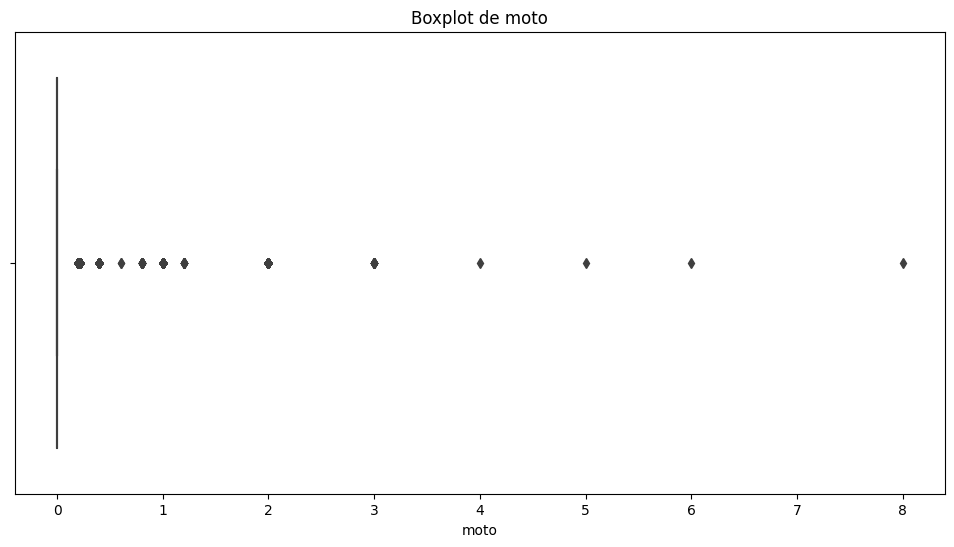

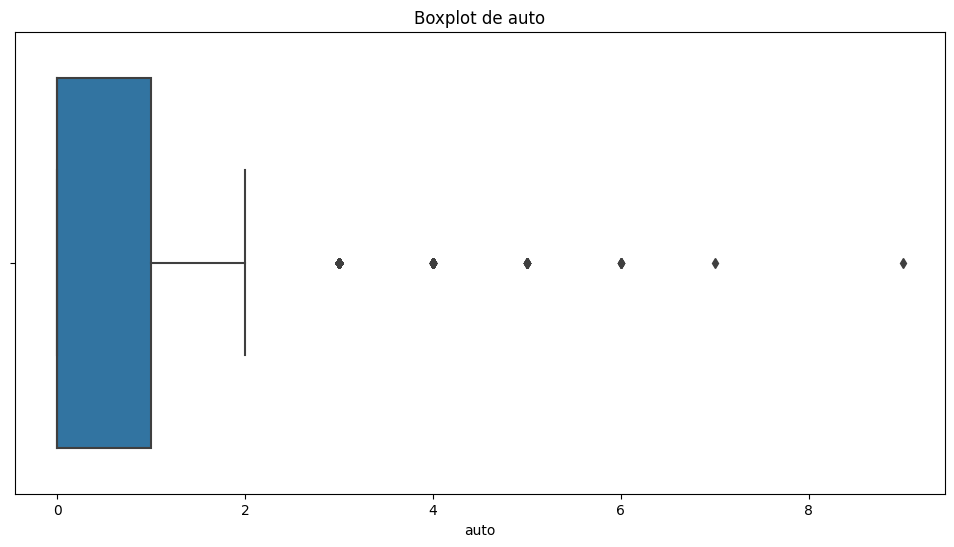

In [135]:
# Lista das variáveis mais importantes
important_vars = ['moto', 'auto']
# Criar boxplots para cada variável
for var in important_vars:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df_acidentes[var])
    plt.title(f'Boxplot de {var}')
    plt.xlabel(var)
    plt.show()

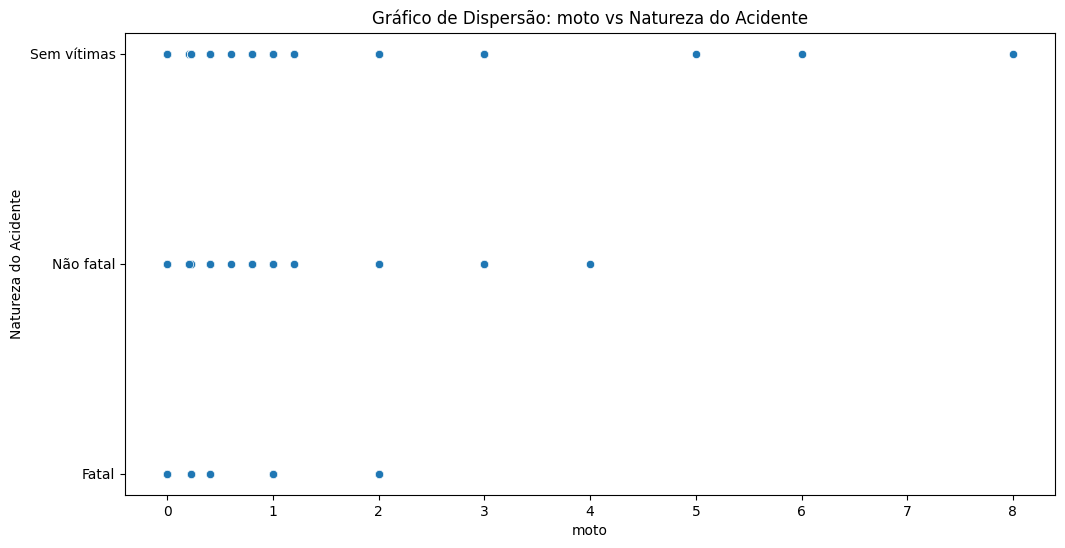

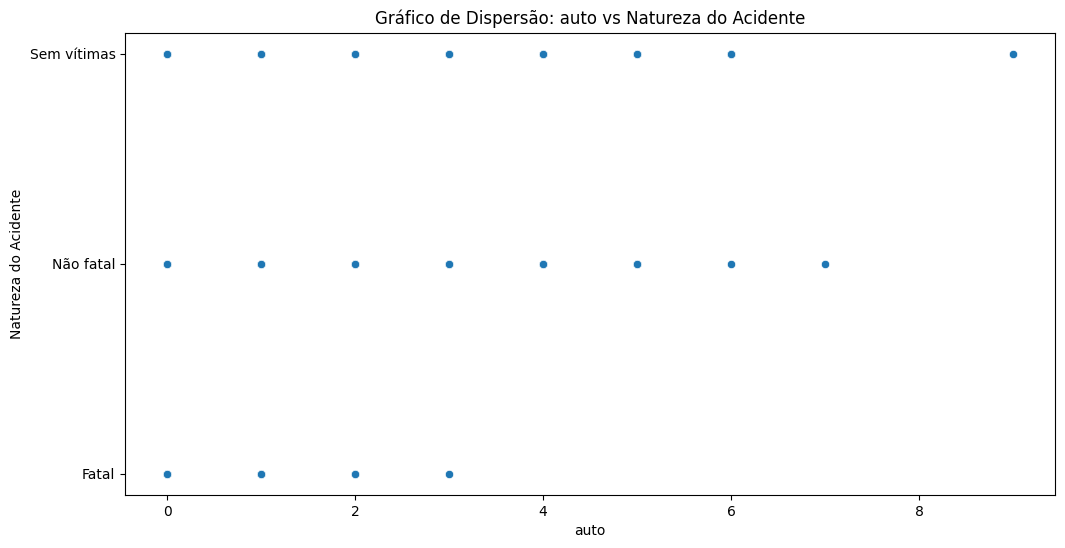

In [136]:
# Lista das variáveis mais importantes
important_vars = ['moto', 'auto']

for var in important_vars:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=df_acidentes[var], y=df_acidentes['natureza_acidente'])
    plt.title(f'Gráfico de Dispersão: {var} vs Natureza do Acidente')
    plt.xlabel(var)
    plt.ylabel('Natureza do Acidente')
    plt.show()


# Análise de dados

#### Variação de acidentes ao longo do tempo

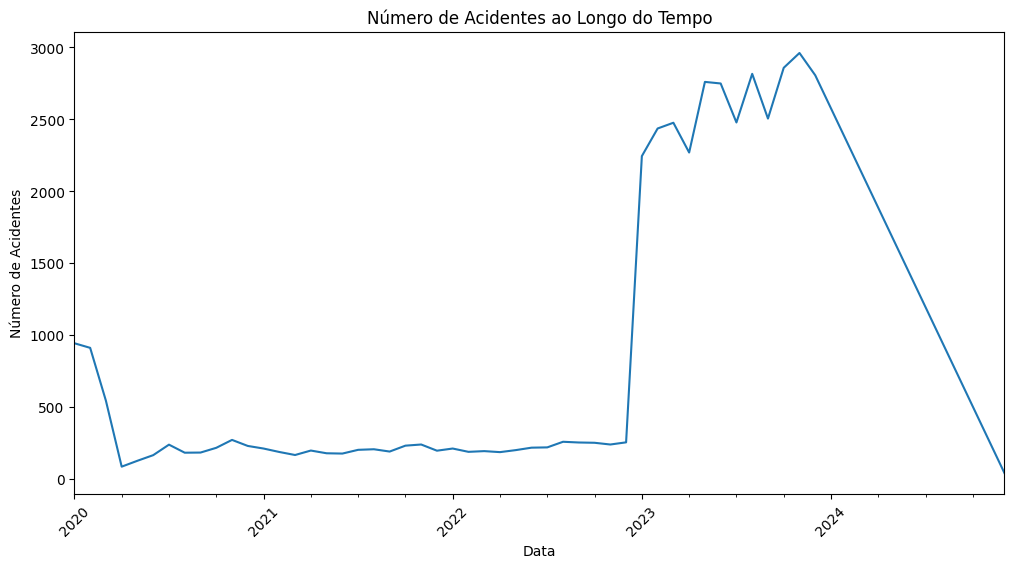

In [106]:
# Resample por mês e contar o número de acidentes por mês
df_acidentes['mes_ano'] = df_acidentes['data'].dt.to_period('M')
accidents_per_month = df_acidentes.groupby('mes_ano').size()

# Plotar o número de acidentes por mês
plt.figure(figsize=(12, 6))
accidents_per_month.plot()
plt.title('Número de Acidentes ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Número de Acidentes')
plt.xticks(rotation=45)
plt.show()

Esse gráfico não condiz com a realidade. Como constatado na etapa de ingestão de dados, nós temos um preenchimento muito maior de datasets no ano de 2023 do que no resto. Vamos refazer o histograma olhando apenas 2023:

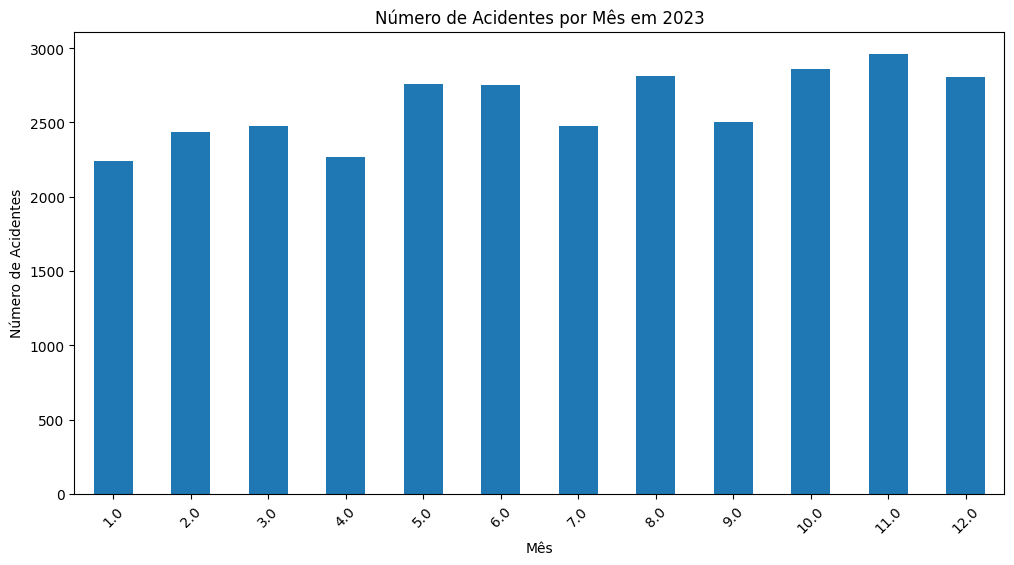

In [133]:
#filtrando somente 2023
df_ano = df_acidentes[df_acidentes['ano'] == 2023]

# Agrupar por mês e contar o número de acidentes por mês
accidents_per_month = df_ano.groupby('mes').size()

# Plotar o número de acidentes por mês para o ano atual
plt.figure(figsize=(12, 6))
accidents_per_month.plot(kind='bar')
plt.title(f'Número de Acidentes por Mês em 2023')
plt.xlabel('Mês')
plt.ylabel('Número de Acidentes')
plt.xticks(rotation=45)
plt.show()


Aqui podemos perceber uma distribuição relativamente regular entre os anos. 

#### Agrupando os dados por dia da semana:

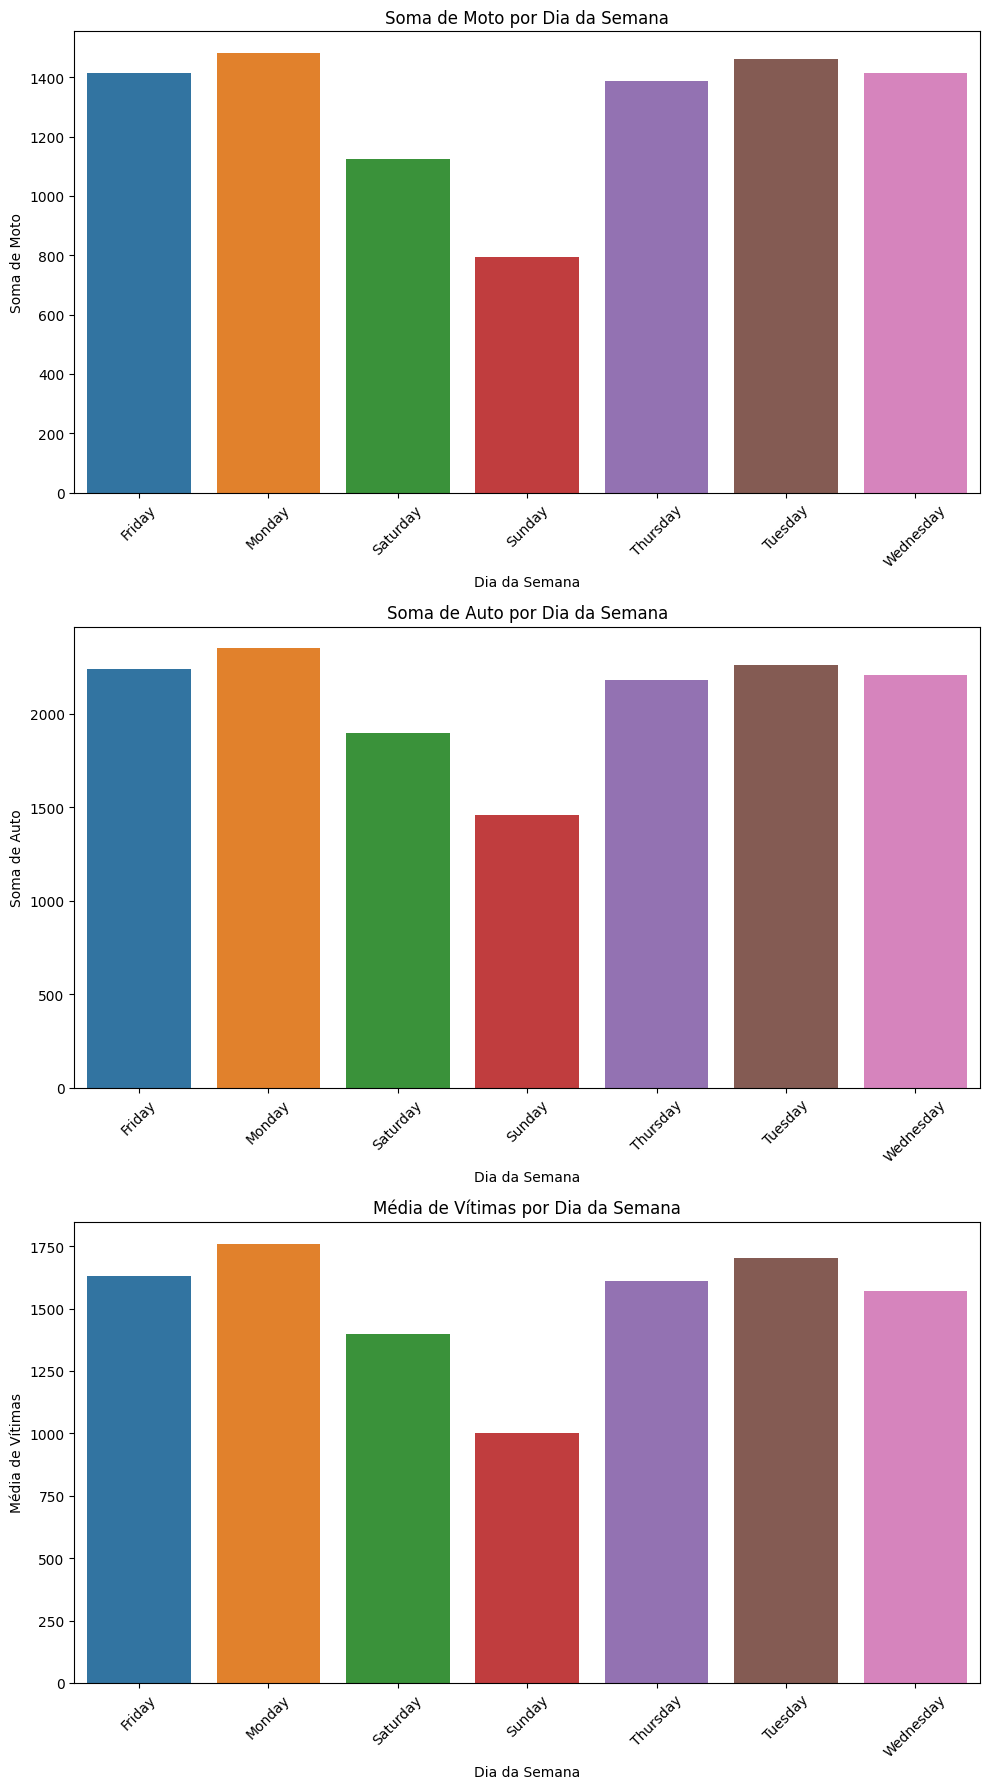

In [110]:
#Bivariado
# Selecionar apenas as colunas de interesse (moto, auto, vitimas)
df_acidentes_interesse = df_acidentes[['dia_da_semana', 'moto', 'auto', 'vitimas']]

# calculando as somas e médias
df_acidentes_sum = df_acidentes_interesse.groupby('dia_da_semana').sum().reset_index()
df_acidentes_mean = df_acidentes_interesse.groupby('dia_da_semana').mean().reset_index()

# Criar subplots para cada variável de interesse
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))

# Loop pelas variáveis de interesse para criar os gráficos de barras
for i, (var, ylabel) in enumerate(zip(['moto', 'auto', 'vitimas'], ['Soma de Moto', 'Soma de Auto', 'Média de Vítimas'])):
    sns.barplot(x='dia_da_semana', y=var, data=df_acidentes_sum, ci=None, ax=axes[i])
    axes[i].set_title(f'{ylabel} por Dia da Semana')
    axes[i].set_xlabel('Dia da Semana')
    axes[i].set_ylabel(ylabel)
    axes[i].tick_params(axis='x', rotation=45)

# Ajustar layout
plt.tight_layout()
plt.show()


A partir desta análise, podemos constatar com clareza que aos domingos ocorrem menos acidentes envolvendo carros ou motos. O resultado faz sentido e vai de encontro ao senso comum.

 Podemos constatar resultados parecidos em uma análise do ibge entre os anos de 2022 e 2023 generalizada para o Brasil inteiro: https://www.estapar.com.br/blog/pesquisa-aponta-dias-mais-acidentes-transito-no-pais#:~:text=J%C3%A1%20o%20dia%20com%20menos,acidentes%20entre%202022%20e%202023.

### Análise de Correlação entre variáveis.

<Axes: >

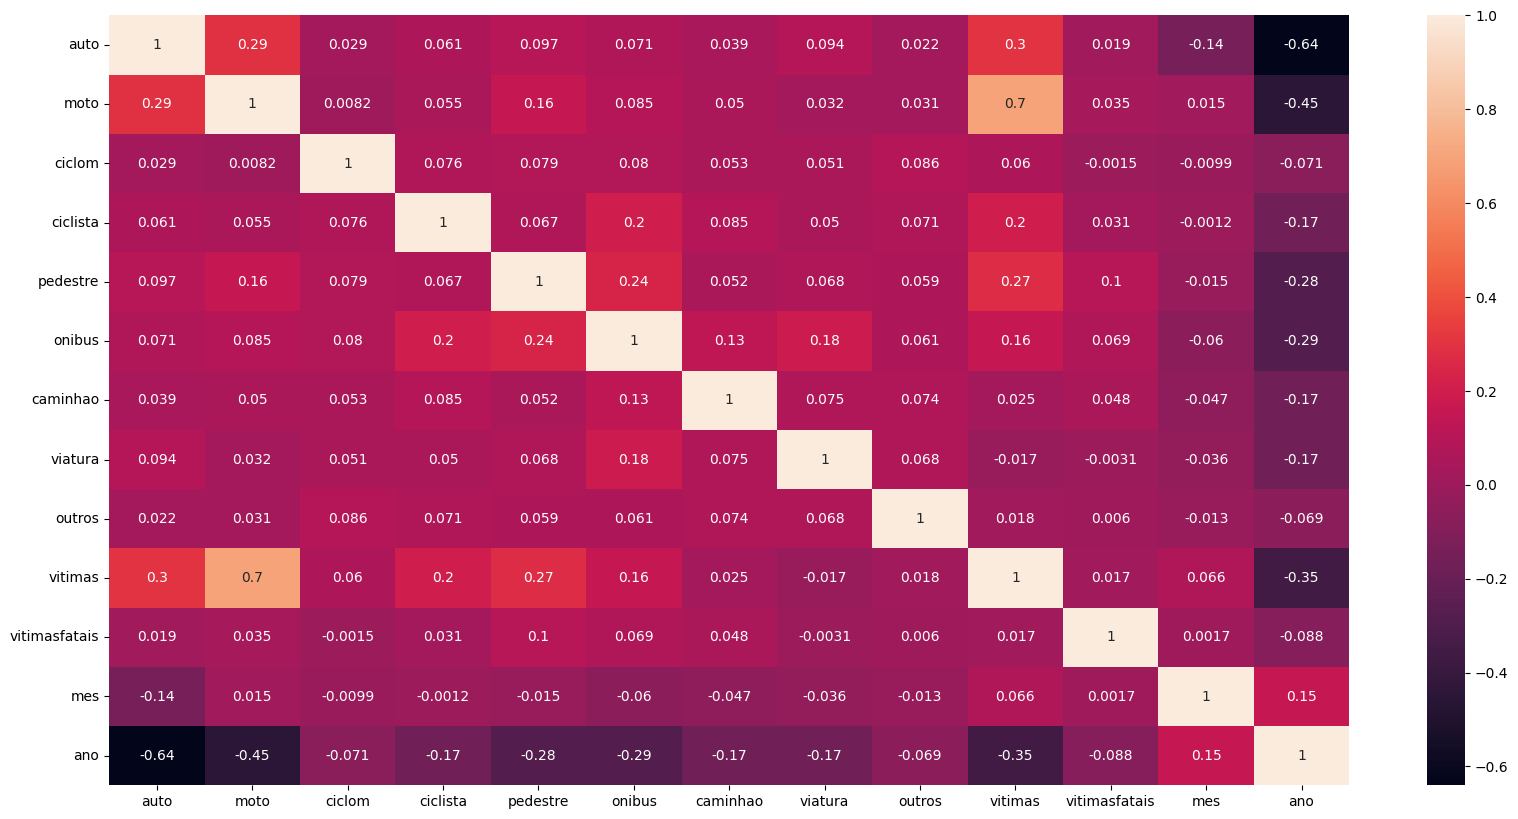

In [111]:
# Análise Multivariada
# Correlação entre variáveis
plt.figure(figsize=(20,10))
df_numeric = df_acidentes.select_dtypes(include=[np.number])
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True)

Vítimas e Moto: Existe uma correlação relativamente forte (aproximadamente 0.71) entre motocicletas (moto) e vítimas não fatais (vitimas). Isso indica que acidentes envolvendo motocicletas têm uma tendência muito alta de gerar vítimas se comparado por exemplo com a coluna de automoveis (0.3).



# Testes de Hipótese

#### Feriados e Acidentes
Hipótese nula (H0): Não existe relação entre feriados e aumentos no índice de acidentes.

Hipótese alternativa (H1): Existe relação entre feriados e aumentos no índice de acidentes.

<Axes: xlabel='num_acidentes', ylabel='Density'>

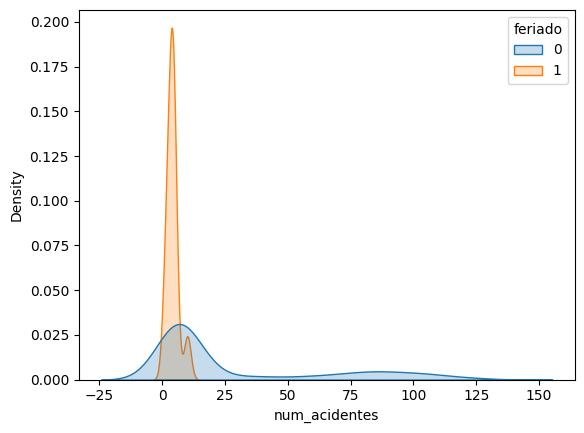

In [112]:
# Definindo uma lista de feriados principais
feriados = [
    "2021-01-01", "2021-03-02", "2021-04-02", "2021-04-21", 
    "2021-05-01", "2021-06-03", "2021-06-24", "2021-09-07", 
    "2021-10-12", "2021-11-02", "2021-11-15", "2021-12-25"
]

df_acidentes_grouped = df_acidentes.groupby(['data']).size().rename('num_acidentes').reset_index()

# Marcando feriados no dataframe
df_acidentes_grouped['feriado'] = df_acidentes_grouped['data'].isin(feriados).astype(int)

sns.kdeplot(data = df_acidentes_grouped, x = 'num_acidentes', hue='feriado', common_norm= False, fill=True)

In [113]:
ks_2samp(df_acidentes_grouped.query('feriado')['num_acidentes'], df_acidentes_grouped.query('feriado == 0')['num_acidentes'] )

KstestResult(statistic=0.6911764705882353, pvalue=0.0, statistic_location=15, statistic_sign=-1)

Nossa análise dos dados de trânsito mostrou que mais acidentes ocorrem durante os feriados do que em dias normais. 

#### Tipo de veículo e quantidade de acidentes.
Hipótese Nula (H0): Não existe diferença significativa na estação do tipo e na natureza do acidente.

Hipótese Alternativa (H1): A diferença na estação do tipo e na natureza do acidente é significativa.

In [114]:
# Criar uma tabela de contingência
tabela_contingencia = pd.crosstab(df_acidentes['natureza_acidente'], df_acidentes['estacao'])

# Realizar o teste qui-quadrado
chi2, p_value, dof, expected = chi2_contingency(tabela_contingencia)

print(f"Chi-squared: {chi2}")
print(f"P-value: {p_value}")




NameError: name 'chi2_contingency' is not defined

#aplicar ks2

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 5))

attrition_by_card = (df_acidentes.groupby('estacao')['natureza_acidente'].value_counts(normalize=True)*100).rename('Percentage').reset_index()
sns.barplot(data=attrition_by_card, x='estacao', y='Percentage', hue='natureza_acidente', ax=ax)
ax.set_title('Comparando a natureza do acidente em diferentes estações do ano')
ax.set_xlabel('Estação do ano')
ax.set_ylabel('Natureza do acidente')
ax.set_ylim(0, 100)
ax.legend(title = 'Natureza do acidente', loc=(1.01, 0.8))
for container in ax.containers: # Displaying values at bars
    ax.bar_label(container, fmt='%.1f%%')

Nossa análise estatística que praticamente não existe relação entre as estações do ano e a natureza dos acidentes de trânsito em Recife. 

# Exportação do dataset refinado.

In [ ]:
nome_arquivo = 'acidentes_recife'
df_acidentes.to_csv(f'data/refined/{nome_arquivo}.csv', sep = ',')